# Statistical Inference

Exploring the data further by examining the statistical trends.

### Load in the data and packages

In [2]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
# See data wrangling report for more details
#load data
spotify = pd.read_csv('../Data/SpotifyFeatures0419.csv')

# Create the sorted dataframe and drop zeros
sort_data = spotify.sort_values('popularity', ascending=False).reset_index()
spotify_ordered = sort_data.drop(['index', 'track_id'], axis=1)
spotify_ordered.index = spotify_ordered.index + 1
spotify_ordered = spotify_ordered[spotify_ordered.popularity > 0]
spotify_ordered[['mode', 'key', 'time_signature']] = \
    spotify_ordered[['mode', 'key', 'time_signature']].astype('category')

In [4]:
#Create table with a column classifying popularity ratings
classified = spotify_ordered.copy()
classified['pop_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity > 50) & (row.popularity < 75):
        score = 'medium'
    elif row.popularity >= 75:
        score = 'popular'
    classified.at[i, 'pop_rating'] = score

## Statistical moments

To begin, using the pandas .describe() method can give general statistical points of reference for each feature in the dataset. This is useful for a quick check on the mean, range and other points of interest.

In [6]:
s = spotify_ordered

s.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
count,111774.000000,111774.000000,1.117740e+05,111774.000000,111774.000000,111774.000000,111774.000000,111774.000000,111774.000000,111774.000000,111774.000000
mean,0.344021,0.577959,2.155524e+05,0.569467,0.206224,0.194912,-9.831834,0.111265,119.474240,0.435165,28.300132
std,0.347000,0.188435,1.197277e+05,0.260992,0.348923,0.167262,6.545899,0.123257,30.155886,0.255739,18.398418
min,0.000000,0.000000,1.314700e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,1.000000
25%,0.032600,0.454000,1.677672e+05,0.395000,0.000000,0.097500,-11.609000,0.038800,95.899750,0.222000,14.000000
50%,0.203000,0.599000,2.036045e+05,0.606000,0.000094,0.124000,-7.785000,0.055500,120.014000,0.415000,26.000000
75%,0.642000,0.722000,2.425312e+05,0.777000,0.287000,0.237000,-5.580000,0.128000,139.869000,0.630000,41.000000
max,0.996000,0.996000,5.040048e+06,1.000000,1.000000,0.999000,1.806000,0.966000,249.983000,1.000000,100.000000


In addition to statistical moments, the above also gives a general idea of how each feature is structured. For example, many features range between 0 and 1, while others are less restricted. The loudness feature even ranges between negative and positive values.

<b>Focusing on the target variable</b>

The .describe() method can also be used on specific variables.

In [8]:
s[['popularity']].describe()

,popularity
count,111774.000000
mean,28.300132
std,18.398418
min,1.000000
25%,14.000000
50%,26.000000
75%,41.000000
max,100.000000


This gives a pretty consice overview of the target variable, popularity. One of the first things that stands out is that the mean and median both are in the 20s. This tells us right away that songs tend to have low popularity scores. Expanding this view, the Inter Quartile Range is from 14 and only extends to 41. Landing a half-way popular song with a score of only 50 would still be a fairly rare event. 

One thing .describe() doesn't mention is the mode.

In [10]:
from scipy import stats
stats.mode(s.popularity)

ModeResult(mode=array([1], dtype=int64), count=array([3217]))

Somewhat unsurprisingly, the mode for popularity is a score of 1.

## Distribution of popularity

Here's a visual of the popularity variable:

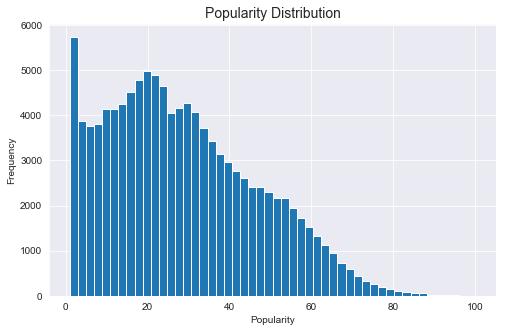

In [11]:
# Inspect shape of popularity variable
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = spotify_ordered['popularity'].plot(kind='hist', bins=50)
_ = plt.xlabel('Popularity')
_ = plt.title('Popularity Distribution', fontsize=14)

The shape hints at a normal shape, but does not appear to be actually normal given the right skew and the prevalence of the lower values. To further test this concept, we can compare the actual distribution to a theoretical normal cumulative density curve.

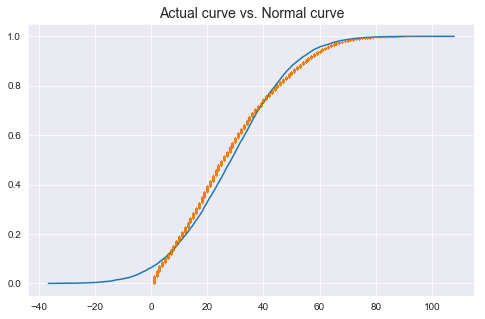

In [42]:
# Create theoretical values based on stats from popularity
theoreticals = np.random.normal(28.3, 18.398, 10000)
x_th = np.sort(theoreticals)
y_th = np.arange(1, len(x_th) + 1) / len(x_th)

x = np.sort(spotify_ordered.popularity)
y = np.arange(1, len(x) + 1) / len(x)

fig = plt.subplots(figsize=(8,5))
_ = plt.plot(x_th, y_th)
_ = plt.plot(x, y, marker='.', linestyle='none', ms=0.1)
_ = plt.title('Actual curve vs. Normal curve', fontsize=14)

The shape of the actual data is surprisingly close to the theoretical. The real difference is just the lack of negative values for the actual data, which means the lower tail is cut off.

Besides visualizations, we can also use packages to test the normality of the data. 

In [27]:
import warnings
warnings.simplefilter("ignore", UserWarning)

from scipy import stats

stat, p = stats.shapiro(spotify_ordered.popularity)

print(p)

0.0


The above code tests the data assuming the distribution is normal. The low p-value suggests that that assumption should be rejected, and confirms the notion that the popularity variable is not normal.

<b>Checking Z-score of popular songs</b>

In [29]:
#find z-score for popular threshold
pop = spotify_ordered['popularity']

z_of_75 = (75 - pop.mean()) / pop.std()
z_of_75

2.538254501540204

## Exploring impact of song mode

One thing to explore is whether or not a song's mode affects its popularity. There are many different types of modes, depending on the musical scales used, but they can generally be classified as either major or minor, and that is how they are handled in the Spotify data. In this case, minor is represented with a 0, while major is 1.<br>
To explore this relationship, we can use inferential statistics to examine if the observed difference in popularity for each mode is significant.

In [54]:
s = spotify_ordered

# Split the dataset based on mode
minor = s[s['mode'] == 0]
major = s[s['mode'] == 1]

# Find the average popularity for each split
min_avg = np.mean(minor.popularity)
maj_avg = np.mean(major.popularity)
obs_diff = min_avg - maj_avg

print('The average popularity for minor is: {num:.{dig}f}'.format(num=min_avg, dig=3))
print('The average popularity for major is: {num:.{dig}f}'.format(num=maj_avg, dig=3))
print('The observed difference between the two is: {num:.{dig}f}'.format(num=obs_diff, dig=3))

The average popularity for minor is: 28.706
The average popularity for major is: 28.040
The observed difference between the two is: 0.666


From the observed results, songs with major tonality are, on average, slightly less popular. The use of hacker statistics can show the odds of getting a similar or more extreme result just by chance, which will help determine whether or not the observed result is significant. 

In [48]:
# Create empty array
perm_diffs = np.empty(20000)

# Randomly assign popularity scores to major and minor
# average the values for each random group
# Calculate difference in averages; repeat 20k times
for i in range(20000):
    concat = np.concatenate((minor.popularity, major.popularity))
    permutation = np.random.permutation(concat)
    perm_min = permutation[:len(minor)]
    perm_maj = permutation[len(minor):]
    perm_diffs[i] = (np.sum(perm_min) / len(perm_min)) - (np.sum(perm_maj) / len(perm_maj))

In [51]:
# Count the total number of times the random results matched or
# exceeded the actual observed results
count = np.sum(perm_diffs >= obs_diff)
count

0

Out of 20,000 random trials, there were zero results where the difference in average popularity between minor songs and major songs matched or exceeded the result observed in the actual data. A p-value doesn't need to be calculated to know that this means the observed result is significant.<br>
I must admit that I'm surprised by this finding, as I would have guessed major tonality to be better suited for popular tastes. But that shows why it's important to analyze the data and test hypotheses.